In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

## Описание проекта

Использование методов машинного обучения при одобрении кредитов. В качестве исходных данных используется датасет с кредитной историй клиентов взятый отсюда: https://www.kaggle.com/datasets/sarodeaditya/loan-defaulter-dataset

Загрузим датасет и ознакомимся с ним.

In [2]:
data = pd.read_csv('Loan_data.csv', sep=',', decimal='.', encoding='utf-8')
data.head()

,Unnamed: 0,Unnamed: 0.1,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,13,NaN,18000.0,18000.0,18000.0,60 months,19.48,471.70,E,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,25,NaN,4225.0,4225.0,4225.0,36 months,14.85,146.16,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,30,NaN,16000.0,16000.0,16000.0,36 months,12.88,538.18,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,31,NaN,24250.0,24250.0,24250.0,60 months,24.24,701.01,F,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,33,NaN,25000.0,25000.0,25000.0,60 months,13.99,581.58,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим сколько записей в нашем датасете.

In [3]:
len(data)

1007987

Для ускорения процесса работы моделей и обработки данных оставим 10% записей.

In [4]:
data = data.sample(frac=0.1, random_state=42)
data = data.reset_index(drop=True)
len(data)

100799

## Описание столбцов

- 'loan_amnt' - сумма кредита,
- 'funded_amnt' - общая сумма кредита выделенная инвесторами,
- 'funded_amnt_inv' - Общая сумма, выделенная инвесторами для этого кредита на данный момент времени,
- 'term' - срок кредита,
- 'int_rate' - процентная ставка,
- 'installment' - ежемесячный платеж,
- 'grade' - присвоенный кредитный рейтинг,
- 'sub_grade' - расширенная классификация рейтинга,
- 'emp_title' - профессия,
- 'emp_length' - срок работы,
- 'home_ownership' - тип владения имуществом,
- 'annual_inc' - годовой доход,
- 'verification_status' - статус проверки,
- 'issue_d' - дата кредита,
- 'loan_status' - статус кредита,
- 'pymnt_plan' - план платежей,
- 'url',
- 'desc' - Описание кредита, предоставленное заемщиком,
- 'purpose' - цель кредита,
- 'title' - расширенная цель кредита,
- 'zip_code' - индекс,
- 'addr_state' - адрес,
- 'dti' - Соотношение долга заемщика к доходу, рассчитанное путем деления ежемесячных платежей по общей сумме долговых обязательств, за исключением ипотеки, на собственную,
- 'delinq_2yrs' - количество дней, прошедших 30+,
- 'earliest_cr_line' - дата открытия первого кредита,
- 'fico_range_low' - нижняя граница, к которому относится fico заемщика,
- 'fico_range_high' - верхняя граница, к которому относится fico заемщика,
- 'inq_last_6mths' - количество обращений кредитов за последний 6 месяцев,
- 'mths_since_last_delinq' - количество месяцев с последней просрочки кредита,
- 'mths_since_last_record' - количество месяцев с последней записи,
- 'open_acc' - количество открытых кредитов,
- 'pub_rec' - количество публичных записей,
- 'revol_bal' - возобновляемый баланс,
- 'revol_util' - Коэффициент использования возобновляемой линии или сумма кредита, которую заемщик использует по отношению ко всему доступному возобновляемому кредиту,
- 'total_acc' - количество всех кредитов,
- 'initial_list_status' - первоначальный статус кредита,
- 'out_prncp'; 'out_prncp_inv' - Оставшаяся непогашенная основная сумма на общую сумму финансирования,
- 'total_pymnt'; 'total_pymnt_inv' - сумма платежей полученная по всем кредитам,
- 'total_rec_prncp' - основная сумма полученная на сегодня,
- 'total_rec_int' - выплаченные проценты,
- 'total_rec_late_fee' - полученные пени,
- 'recoveries' - последующие списания,
- 'collection_recovery_fee' - последующие пени, полученные коллекторами,
- 'last_pymnt_d' - последняя дата платежа,
- 'last_pymnt_amnt' - сумма последнего платежа,
- 'next_pymnt_d' - следующая дата платежа,
- 'last_credit_pull_d' - ближайшая дата, по которой кредитор отзвал кредит,
- 'last_fico_range_high' - последняя верхняя граница, к которому относится fico заемщика,
- 'last_fico_range_low' - последняя нижняя граница, к которому относится fico заемщика,
- 'collections_12_mths_ex_med' - Количество сборов за 12 месяцев без учета медицинских сборов,
- 'mths_since_last_major_derog' - количество месяцев с 90+,
- 'policy_code' - код полиса,
- 'application_type' - тип приложения,
- 'annual_inc_joint' - Совокупный годовой доход, о котором сами сообщили созаемщики при регистрации,
- 'dti_joint' - Коэффициент, рассчитанный с использованием общих ежемесячных платежей созаемщиков по общим долговым обязательствам, исключая ипотечные кредиты и запрошенный кредит LC, деленный на совокупный ежемесячный доход созаемщиков, о котором они сами сообщили.,
- 'verification_status_joint' - Указывает, был ли совместный доход созаемщиков ,
- 'acc_now_delinq' - Количество счетов, по которым заемщик в настоящее время является неплатежеспособным.,
- 'tot_coll_amt' - общая сумма выданных счетов,
- 'tot_cur_bal' - общий текущий баланс по всем счетам,
- 'open_acc_6m' - открытые счета 6 месяцев назад,
- 'open_act_il' - количество активных рассрочек/платежей,
- 'open_il_12m' - количество активных рассрочек/платежей за последние 12 месяцев,
- 'open_il_24m' - количество аквтивных рассрочек/платежей за последние 24 месяца,
- 'mths_since_rcnt_il' - количество месяцев с последней рассрочки,
- 'total_bal_il' - общий баланс по рассрочкам,
- 'il_util' - Отношение общего текущего баланса к высокому кредиту/кредитному лимиту по всем платежам,
- 'open_rv_12m' - Количество возобновляемых сделок, открытых за последние 12 месяцев,
- 'open_rv_24m' - Количество возобновляемых сделок, открытых за последние 24 месяцев,
- 'max_bal_bc' - Максимальный текущий остаток задолженности по всем возобновляемым счетам,
- 'all_util' - баланс до кредитного лимита по всем сделкам,
- 'total_rev_hi_lim' - Общий возобновляемый высокий кредит/кредитный лимит,
- 'inq_fi' - Количество запросов о личных финансах,
- 'total_cu_tl' - количество сделок,
- 'inq_last_12m' - количество кредитных запросов за последние 12 месяцев,
- 'acc_open_past_24mths' - количество сделок, открытых за последние 24 месяца,
- 'avg_cur_bal' - средний текущий баланс,
- 'bc_open_to_buy' - баланс, открытый для покупок,
- 'bc_util' - Отношение общего текущего баланса к высокому кредиту/кредитному лимиту для всех счетов банковских карт.,
- 'chargeoff_within_12_mths' - количество списаний за последние 12 месяцев,
- 'delinq_amnt' - Просроченная сумма задолженности по счетам, по которым заемщик в настоящее время просрочен.,
- 'mo_sin_old_il_acct' - Количество месяцев с последнего открытого счета в рассрочку,
- 'mo_sin_old_rev_tl_op' - Количество месяцев с первого открытого возобновляемого счета,
- 'mo_sin_rcnt_rev_tl_op' - Количество месяцев с последнего открытого возобновляемого счета,
- 'mo_sin_rcnt_tl' - Количество месяцев с последнего открытого счета,
- 'mort_acc' - количество счетов с ипотекой,
- 'mths_since_recent_bc' - количество месяцев с открытия последней банковской карты,
- 'mths_since_recent_bc_dlq' - количество месяцев с последней просрочки по банковским картам,
- 'mths_since_recent_inq' - количество месяцев с последнего запроса на кредит,
- 'mths_since_recent_revol_delinq' - количество месяцев с последней просрочки по возобновляемым счетам,
- 'num_accts_ever_120_pd' - количество счетов, просроченных на 120 и более дней,
- 'num_actv_bc_tl' Количество активных в настоящее время счетов банковских карт
- 'num_actv_rev_tl' - Количество активных в настоящее время оборотных сделок,
- 'num_bc_sats' - Количество одобренных счетов по банковским картам,
- 'num_bc_tl' - Количество счетов по банковским картам,
- 'num_il_tl' - Количество счетов в рассрочку,
- 'num_op_rev_tl' - Количество открытых оборотных счетов,
- 'num_rev_accts' - Количество оборотных счетов,
- 'num_rev_tl_bal_gt_0' - Количество оборотных сделок с балансом >0,
- 'num_sats' - Количество одобренных счетов,
- 'num_tl_120dpd_2m' - Количество счетов, просроченных в настоящее время на 120 дней (обновлено за последние 2 месяца),
- 'num_tl_30dpd' - Количество счетов, просроченных в настоящее время на 30 дней (обновлено за последние 2 месяца),
- 'num_tl_90g_dpd_24m' - Количество счетов, просроченных на 90 или более дней за последние 24 месяца,
- 'num_tl_op_past_12m' - Количество счетов, открытых за последние 12 месяцев,
- 'pct_tl_nvr_dlq' - Процент сделок, которые никогда не были просрочены,
- 'percent_bc_gt_75' - Процент всех счетов по банковским картам > 75% от лимита.,
- 'pub_rec_bankruptcies' - Количество зарегистрированных банкротсв,
- 'tax_liens' - Количество налоговых залогов,
- 'tot_hi_cred_lim' - Общий высокий кредитный лимит,
- 'total_bal_ex_mort' - Общий кредитный баланс без ипотеки,
- 'total_bc_limit' - Общий баланс по кредитным картам,
- 'total_il_high_credit_limit' - Самый высокий взнос,
- 'revol_bal_joint' - Сумма возобновляемого кредитного остатка созаемщиков, за вычетом дублирующих остатков,
- 'sec_app_fico_range_low',
- 'sec_app_fico_range_high' Диапазон FICO (низкий) для вторичного заявителя,
- 'sec_app_earliest_cr_line' - Самая ранняя кредитная линия на момент подачи заявки для вторичного заявителя,
- 'sec_app_inq_last_6mths' - Кредитные запросы за последние 6 месяцев на момент подачи заявления для второго заявителя,
- 'sec_app_mort_acc' - Количество ипотечных счетов на момент подачи заявления для второго заявителя,
- 'sec_app_open_acc' - Количество открытых сделок на момент подачи заявки для вторичного заявителя,
- 'sec_app_revol_util' - Отношение общего текущего баланса к высокому кредиту/кредитному лимиту для всех возобновляемых счетов,
- 'sec_app_open_act_il' - Количество активных в настоящее время сделок с рассрочкой платежа на момент подачи заявки для вторичного заявителя,
- 'sec_app_num_rev_accts' - Количество оборотных счетов на момент подачи заявления для второго заявителя,
- 'sec_app_chargeoff_within_12_mths' - Количество списаний в течение последних 12 месяцев на момент подачи заявления для второго заявителя,
- 'sec_app_collections_12_mths_ex_med' - Количество сборов за последние 12 месяцев за исключением медицинских сборов на момент подачи заявления для вторичного заявителя,
- 'sec_app_mths_since_last_major_derog' - Количество месяцев с момента последнего 90-дневного или худшего рейтинга на момент подачи заявления для вторичного заявителя,
- 'hardship_flag' - Указывает, находится ли заемщик в программе помощи в трудных условиях или нет,
- 'hardship_type' - Описывает план помощи в трудных условиях,
- 'hardship_reason' - Описывает причину, по которой был предложен план помощи в трудных условиях,
- 'hardship_status' - Описывает, является ли план поддержки активным, ожидающим, отмененным, завершенным или нарушенным,
- 'deferral_term' - Процентная выплата, которую заемщик обязался производить каждый месяц, пока он находится на льготном плане,
- 'hardship_amount' - Выплата процентов, которую заемщик обязался производить каждый месяц, пока он находится в трудном положении,
- 'hardship_start_date' - Дата начала периода действия плана в трудных условиях,
- 'hardship_end_date' - Дата окончания периода действия плана в трудных условиях,
- 'payment_plan_start_date' - день, когда начал работать план,
- 'hardship_length' - Просроченные дни по счету на дату начала действия плана в трудных условиях,
- 'hardship_dpd' -  Просроченные дни по счету на дату начала действия плана в трудных условиях,
- 'hardship_loan_status' - Статус кредита на дату начала действия плана помощи в трудных условиях,
- 'orig_projected_additional_accrued_interest' - Первоначальная прогнозируемая дополнительная сумма процентов, которая будет начисляться по данному плану выплат в случае трудностей на дату начала трудностей.
- 'hardship_payoff_balance_amount' - Сумма остатка выплаты на дату начала действия плана в трудных условиях,
- 'hardship_last_payment_amount' - Последняя сумма платежа на дату начала действия плана в трудных условиях,
- 'disbursement_method' - Метод, с помощью которого заемщик получает свой кредит,
- 'debt_settlement_flag' - Указывает, работает ли заемщик, который списал средства, с компанией по урегулированию задолженности,
- 'debt_settlement_flag_date' - ближайшая дата, когда был выставлен debt_settlement_flag,
- 'settlement_status' - Статус плана урегулирования задолженности заемщика,
- 'settlement_date' - Дата, когда заемщик соглашается с планом урегулирования,
- 'settlement_amount' - Сумма кредита, которую заемщик согласился оплатить,
- 'settlement_percentage' - Сумма расчета в процентах от суммы остатка платежа по кредиту,
- 'settlement_term' - Количество месяцев, в течение которых заемщик будет находиться в плане урегулирования

## EDA & Preprocessing

Перед началом моделирования проведем первичный анализ данных. Также преобразуем категориальные переменные. Посмотрим на распределение целевой.

Посмотрим на типы данных в нашем датасете.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100799 entries, 0 to 100798
Columns: 152 entries, Unnamed: 0 to settlement_term
dtypes: float64(113), int64(2), object(37)
memory usage: 116.9+ MB


В нашем датасете 152 столбца. Из них 115 числовые поля, 37 - строковые. Выведем тип данных по каждому столбцу.

In [6]:
for col in data.columns:
    print(str(col) + ' - ' + str(data[col].dtypes))

Unnamed: 0 - int64
Unnamed: 0.1 - int64
member_id - float64
loan_amnt - float64
funded_amnt - float64
funded_amnt_inv - float64
term - object
int_rate - float64
installment - float64
grade - object
sub_grade - object
emp_title - object
emp_length - object
home_ownership - object
annual_inc - float64
verification_status - object
issue_d - object
loan_status - object
pymnt_plan - object
url - object
desc - object
purpose - object
title - object
zip_code - object
addr_state - object
dti - float64
delinq_2yrs - float64
earliest_cr_line - object
fico_range_low - float64
fico_range_high - float64
inq_last_6mths - float64
mths_since_last_delinq - float64
mths_since_last_record - float64
open_acc - float64
pub_rec - float64
revol_bal - float64
revol_util - float64
total_acc - float64
initial_list_status - object
out_prncp - float64
out_prncp_inv - float64
total_pymnt - float64
total_pymnt_inv - float64
total_rec_prncp - float64
total_rec_int - float64
total_rec_late_fee - float64
recoveries - 

Проверим есть ли полностью дублирующие строки в данных. Если да, то удалим их.

In [7]:
data = data.drop_duplicates()
len(data)

100799

Видим, что в данных не были найдены полностью дублирующие строки. Теперь проверим пропуски в данных.

In [8]:
for col in data.columns:
    print(str(col) + ' - ' + str(round(data[col].isnull().sum() / len(data) * 100, 2)))

Unnamed: 0 - 0.0
Unnamed: 0.1 - 0.0
member_id - 100.0
loan_amnt - 0.0
funded_amnt - 0.0
funded_amnt_inv - 0.0
term - 0.0
int_rate - 0.0
installment - 0.0
grade - 0.0
sub_grade - 0.0
emp_title - 6.7
emp_length - 5.96
home_ownership - 0.0
annual_inc - 0.01
verification_status - 0.0
issue_d - 0.0
loan_status - 0.0
pymnt_plan - 0.0
url - 0.0
desc - 87.35
purpose - 0.0
title - 1.62
zip_code - 0.0
addr_state - 0.0
dti - 0.04
delinq_2yrs - 0.01
earliest_cr_line - 0.01
fico_range_low - 0.0
fico_range_high - 0.0
inq_last_6mths - 0.01
mths_since_last_delinq - 50.92
mths_since_last_record - 83.14
open_acc - 0.01
pub_rec - 0.01
revol_bal - 0.0
revol_util - 0.08
total_acc - 0.01
initial_list_status - 0.0
out_prncp - 0.0
out_prncp_inv - 0.0
total_pymnt - 0.0
total_pymnt_inv - 0.0
total_rec_prncp - 0.0
total_rec_int - 0.0
total_rec_late_fee - 0.0
recoveries - 0.0
collection_recovery_fee - 0.0
last_pymnt_d - 0.24
last_pymnt_amnt - 0.0
next_pymnt_d - 96.36
last_credit_pull_d - 0.01
last_fico_range_high

Как мы видим, в данных присутствует столбцы, по которым много пустых значений. Так как эти данные не имеют смысловой нагрузки для анализа, удалим из датасета данные, в которых более 90% пустые.

In [9]:
for col in data.columns:
    null_flag = data[col].isnull().sum() / len(data)
    if null_flag > 0.9:
        data = data.drop(col, axis=1)

Также удалим столбцы Unnamed. Так как в них хранится информация по id клиента. 

In [10]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

Из данных также удалим данные по клиентам, связанные с адресом, индексом. Так как эти данные не представляют интереса для анализа.

In [11]:
data = data.drop(['url', 'desc', 'zip_code', 'addr_state'], axis=1)

Теперь посмотрим сколько в нашем датасете осталось столбцов.

In [12]:
print('В датасете осталось ' + str(len(data.columns)) + ' столбцов')

В датасете осталось 108 столбцов


Удалим из датасета строки, где отсутствует все данные.

In [13]:
data = data.dropna(how='all')
data = data.reset_index(drop=True)

Посмотрим на типы данных столбцов, в которых остались пустые значения

In [14]:
for col in data.columns:
    null_flag = data[col].isnull().sum()
    if null_flag > 0:
        print(str(col) + ' - ' + str(data[col].dtypes) + '. Доля пустых значений: ' + str(round(null_flag / len(data) * 100, 2)))

emp_title - object. Доля пустых значений: 6.7
emp_length - object. Доля пустых значений: 5.96
annual_inc - float64. Доля пустых значений: 0.0
title - object. Доля пустых значений: 1.62
dti - float64. Доля пустых значений: 0.03
delinq_2yrs - float64. Доля пустых значений: 0.0
earliest_cr_line - object. Доля пустых значений: 0.0
inq_last_6mths - float64. Доля пустых значений: 0.0
mths_since_last_delinq - float64. Доля пустых значений: 50.92
mths_since_last_record - float64. Доля пустых значений: 83.14
open_acc - float64. Доля пустых значений: 0.0
pub_rec - float64. Доля пустых значений: 0.0
revol_util - float64. Доля пустых значений: 0.07
total_acc - float64. Доля пустых значений: 0.0
last_pymnt_d - object. Доля пустых значений: 0.24
last_credit_pull_d - object. Доля пустых значений: 0.0
collections_12_mths_ex_med - float64. Доля пустых значений: 0.02
mths_since_last_major_derog - float64. Доля пустых значений: 74.49
acc_now_delinq - float64. Доля пустых значений: 0.0
tot_coll_amt - floa

Практически все столбцы с пустыми значениями имеют числовой формат. Пустые значения в них можно заменить на 0, так как смысловая нагрузка этих полей - сумма счета, количество счетом, количество месяцев.
Выведем названия пустых строковых столбцов и количество уникальных значений в них.

In [15]:
for col in data.columns:
    null_flag = data[col].isnull().sum()
    if null_flag > 0 and data[col].dtype == 'object':
        print(col + '. Количество уникальных значений: ' + str(len(data[col].unique())))

emp_title. Количество уникальных значений: 46803
emp_length. Количество уникальных значений: 12
title. Количество уникальных значений: 8685
earliest_cr_line. Количество уникальных значений: 655
last_pymnt_d. Количество уникальных значений: 136
last_credit_pull_d. Количество уникальных значений: 127


Столбец emp_title описывает профессию клиента. Для дальнейшего анализа данный столбец не понадобиться, так как в нем очень много уникальных значений.
Столбец title является дублирующим для столбца purpose (цель кредита), так как в нем отображается более полная информация о кредите. Для дальнейшего анализа данный столбец нам не понадобится.

Посмотрим какие значения принимает столбец emp_length (срок работы).

In [16]:
data['emp_length'].value_counts(dropna=False)

10+ years    32828
2 years       9023
< 1 year      8127
3 years       8088
1 year        6722
5 years       6305
4 years       6051
NaN           6006
6 years       5039
7 years       4476
8 years       4399
9 years       3730
Name: emp_length, dtype: int64

Заменим пустоты на "Нет данных", так как мы не знаем сколько работали указанные клиенты на момент оформления кредита.

In [17]:
data['emp_length'] = data['emp_length'].fillna('No data')

Заменим значения на 0 в числовых данных

In [18]:
for col in data.columns:
    null_flag = data[col].isnull().sum()
    if null_flag > 0 and data[col].dtype == 'float64':
        data[col] = data[col].fillna(0)

Построим матрицу корреляций.

In [19]:
df_corr = data.corr()
df_corr.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
loan_amnt,1.000000,0.999293,0.997456,0.162647,0.951264,0.335308,0.033568,0.002950,0.090333,0.090333,...,-0.016979,0.009229,0.101445,0.051823,-0.089132,0.009416,0.330917,0.284408,0.358080,0.215204
funded_amnt,0.999293,1.000000,0.998286,0.162832,0.952346,0.335264,0.034146,0.003230,0.089082,0.089081,...,-0.016750,0.010895,0.106846,0.053631,-0.088734,0.009619,0.332577,0.286121,0.359790,0.216760
funded_amnt_inv,0.997456,0.998286,1.000000,0.163314,0.950470,0.334471,0.035403,0.003584,0.088069,0.088068,...,-0.016171,0.014590,0.118349,0.057446,-0.087785,0.010013,0.335215,0.289026,0.362498,0.219527
int_rate,0.162647,0.162832,0.163314,1.000000,0.176513,-0.064898,0.141101,0.047618,-0.413759,-0.413757,...,0.025531,0.205060,0.044970,0.254492,0.051395,0.015861,-0.092079,0.029874,-0.194504,0.019425
installment,0.951264,0.952346,0.950470,0.176513,1.000000,0.323984,0.037994,0.013215,0.037416,0.037415,...,-0.010912,0.030065,0.101435,0.072619,-0.080005,0.016650,0.300801,0.272746,0.329796,0.203454


Так как в данных много столбцов. Посмотрим какие поля коррелируют сильнее между собой. Создадим словарь

In [20]:
multicorr_dict = {}
for col in df_corr.columns:
    df_check = df_corr[(abs(df_corr[col]) >= 0.8) & (df_corr[col] != 1)]
    multicorrs = df_check.index.values.tolist()
    
    if len(multicorrs) != 0:
        multicorr_dict[col] = multicorrs

In [21]:
multicorr_dict

{'loan_amnt': ['funded_amnt', 'funded_amnt_inv', 'installment'],
 'funded_amnt': ['loan_amnt', 'funded_amnt_inv', 'installment'],
 'funded_amnt_inv': ['loan_amnt', 'funded_amnt', 'installment'],
 'installment': ['loan_amnt', 'funded_amnt', 'funded_amnt_inv'],
 'fico_range_low': ['fico_range_high'],
 'fico_range_high': ['fico_range_low'],
 'open_acc': ['num_sats'],
 'out_prncp': ['out_prncp_inv'],
 'out_prncp_inv': ['out_prncp'],
 'total_pymnt': ['total_pymnt_inv', 'total_rec_prncp'],
 'total_pymnt_inv': ['total_pymnt', 'total_rec_prncp'],
 'total_rec_prncp': ['total_pymnt', 'total_pymnt_inv'],
 'recoveries': ['collection_recovery_fee'],
 'collection_recovery_fee': ['recoveries'],
 'last_fico_range_high': ['last_fico_range_low'],
 'last_fico_range_low': ['last_fico_range_high'],
 'tot_cur_bal': ['avg_cur_bal', 'tot_hi_cred_lim'],
 'open_il_12m': ['open_il_24m'],
 'open_il_24m': ['open_il_12m'],
 'il_util': ['all_util'],
 'open_rv_12m': ['open_rv_24m'],
 'open_rv_24m': ['open_rv_12m'],
 

Можно сделать следующие выводы:
- Видно, что часто коррелируемые поля - это поля, характеризующие возобновляемые кредиты (поля с "rev") и кредитные карты (поля с "bc"). Это связано с тем, что кредитные карты по сути являются возобновляемыми. Так как возобновляемые кредиты более широкое понятие, будем использовать их для дальнейшего анализа. Это поля: revol_util, num_actv_rev_tl, num_rev_accts, revol_bal. Коррелируемые с ними поля удаляем.
- loan_amnt, funded_amnt, installment практически об одном и том же, поэтому для дальнейшего анализа можно оставить только одно. Оставим loan_amnt.
- fico_range определяют скоринговый балл клиента. Для дальнейшего анализа будем использовать наихудший скоринг по верхней границе.
- mths_since_last_delinq оставляем для дальнейшего анализа как более полное с точки зрения смысла. Схожие поля mths_since_recent_revol_delinq и mths_since_recent_bc_dlq удаляем.
- open_acc (количество активных счетов) коррелирует с двумя похожими полями, которую несут такую же смысловую нагрузку. Эти поля убираем.
- out_prncp оставляем, схожее удаляем. 
- total_pmnt оставляем, схожее удаляем.
- recoveries оставляем, схожее удаляем.
- total_bal_il оставляем, схожее удаляем.
- avg_cur_bal - оценка среднего баланса более интересна с точки зрения анализа.
- num_tl_op_past_12m оставляем, так как оно более полное и включает все кредиты.
- acc_open_past_24mths оставляем, так как оно более полное и включает все кредиты. 
- bc_open_to_buy оставляем, так как оно показывает, сколько клиенту доступно для покупки по кредитной карте. И более интересно, чем общий кредитный лимит по всем картам.
- open_il_12m и open_rv_12m оставляем, так как в них отражена более свежая история по открытым счетам.
- il_util оставляем, схожее удаляем.

Создадим список полей, которые мы оставляем

In [22]:
cols_to_leave = ['revol_util', 'num_actv_rev_tl', 'num_rev_accts', 'revol_bal', 'loan_amnt', 'mths_since_last_delinq', 'open_acc', 'out_prncp', 'total_pmnt', 'recoveries', 'total_bal_il', 'avg_cur_bal', 'num_tl_op_past_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'fico_range_high', 'last_fico_range_high', 'open_il_12m', 'open_rv_12m', 'il_util']

Создадим список всех коррелируемых полей, а затем выделим те столбцы, которые нужно удалить

In [23]:
cols_corr = []

for col in df_corr.columns:
    df_check = df_corr[(abs(df_corr[col]) >= 0.8) & (df_corr[col] != 1)]
    corr_list = df_check.index.values.tolist()
    
    if len(corr_list) != 0:
        for corr_col in corr_list:
            cols_corr.append(corr_col)

cols_corr = list(set(cols_corr))

In [24]:
cols_to_del = cols_corr.copy()

for col_corr in cols_corr:
    for col in cols_to_leave:
        if col_corr == col:
            cols_to_del.remove(col_corr)

In [25]:
cols_to_del

['tot_cur_bal',
 'collection_recovery_fee',
 'num_bc_sats',
 'bc_util',
 'out_prncp_inv',
 'total_il_high_credit_limit',
 'all_util',
 'total_bal_ex_mort',
 'num_sats',
 'num_rev_tl_bal_gt_0',
 'total_bc_limit',
 'tot_hi_cred_lim',
 'total_pymnt',
 'num_op_rev_tl',
 'fico_range_low',
 'funded_amnt',
 'total_pymnt_inv',
 'num_actv_bc_tl',
 'last_fico_range_low',
 'open_il_24m',
 'total_rec_prncp',
 'installment',
 'open_rv_24m',
 'funded_amnt_inv',
 'num_bc_tl',
 'percent_bc_gt_75']

Удалим из датасета коррелируемые столбцы и текстовые столбцы, которые были определены ранее. Также удалим всё, что связано с датами.
Для начала определим поля, которые являются датами.

In [26]:
for col in data.columns:
    if data[col].dtype == 'object':
        try:
            data[col] = pd.to_datetime(data[col])
        except ValueError:
            pass

Создадим список, в котором определим названия полей с датами

In [27]:
col_dates = data.select_dtypes(include=[np.datetime64]).columns.tolist()
col_dates

['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

В данных присутствуют два поля, характеризующих буквенного обозначения кредитного рейтинга. Grade и sub_grade. Второе поле более расширенное, поэтому имеет смысл удалить поле grade.
Также имеет смысл удалить поле, в котором только одно уникальное значение, так как оно не будет иметь никакой смысловой нагрузки для анализа. Найдем его.

In [28]:
for col in data.columns:
    val_cnt = len(data[col].unique())
    if val_cnt == 1:
        print(col)

policy_code


Поле policy_code имеет одно значение, поэтому удалим его из дальнейшего рассмотрения. Создадим общий список, в котором определим все поля для удаления

In [29]:
cols_to_del.append('emp_title')
cols_to_del.append('title')
cols_to_del.append('grade')
cols_to_del.append('policy_code')

for col in col_dates:
    cols_to_del.append(col)
    
cols_to_del

['tot_cur_bal',
 'collection_recovery_fee',
 'num_bc_sats',
 'bc_util',
 'out_prncp_inv',
 'total_il_high_credit_limit',
 'all_util',
 'total_bal_ex_mort',
 'num_sats',
 'num_rev_tl_bal_gt_0',
 'total_bc_limit',
 'tot_hi_cred_lim',
 'total_pymnt',
 'num_op_rev_tl',
 'fico_range_low',
 'funded_amnt',
 'total_pymnt_inv',
 'num_actv_bc_tl',
 'last_fico_range_low',
 'open_il_24m',
 'total_rec_prncp',
 'installment',
 'open_rv_24m',
 'funded_amnt_inv',
 'num_bc_tl',
 'percent_bc_gt_75',
 'emp_title',
 'title',
 'grade',
 'policy_code',
 'issue_d',
 'earliest_cr_line',
 'last_pymnt_d',
 'last_credit_pull_d']

## Подготовим данные для анализа:
- Преобразуем целевую переменную, так как она категориальная.
- Преобразуем категориальные переменные в dummy переменные.
- Числовые данные стандратизируем. Это необходимо для построения одной из моделей.
- Исключим ненужные переменные.

Для начала посмотрим, какие данные принимает целевая переменная loan_status

In [30]:
data['loan_status'].value_counts(dropna=False)

Fully Paid                                             69989
Charged Off                                            27132
Late (31-120 days)                                      2139
In Grace Period                                          854
Late (16-30 days)                                        404
Does not meet the credit policy. Status:Fully Paid       202
Does not meet the credit policy. Status:Charged Off       71
Default                                                    3
Name: loan_status, dtype: int64

Как мы видим, в нашей целевой несколько значений. Основные значения Fully Paid и Charged Off. Преобразуем данные в 0 и 1.

In [31]:
data['loan_status'] = np.where(data['loan_status'].str.contains('Fully Paid', regex=False), 0, 1)
data['loan_status'].value_counts(normalize=True)

0    0.696381
1    0.303619
Name: loan_status, dtype: float64

После всех преобразований можно сделать вывод, что в нашем таргете 30% целевых событий.

Определим поля, которые мы будем преобразовать в dummy.

In [32]:
cols_for_dummy = data[data.columns[~data.columns.isin(cols_to_del)]].select_dtypes(include='object').columns
cols_for_dummy

Index(['term', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status',
       'application_type', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')

Определим столбцы, которые мы будем удалять после преобразования в дамми с учетом ранее определенных для удаления полей.

In [33]:
cols_for_drop = data.columns[data.columns.isin(cols_to_del) | data.columns.isin(cols_for_dummy)]

Определим столбцы, которые будут стандартизироваться в рамках построения одной из моделей

In [34]:
num_cols = data[data.columns[~data.columns.isin(cols_to_del)]].select_dtypes(include='float64').columns
num_cols

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'last_fico_range_high', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'max_bal_bc',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_rece

Запишем функцию для преобразования датасета

In [35]:
def data_preprocessing(data, categorial_cols, cols_for_del):
    
    #Преобразование категориальных переменных
    data_dumm = pd.get_dummies(data[categorial_cols], prefix=categorial_cols, prefix_sep='=')
    data = pd.concat([data, data_dumm], axis=1)
    
    #Удаление переменных
    data = data.drop(cols_for_del, axis=1)
    
    return data

In [149]:
data_preproc = data_preprocessing(data,
                                  categorial_cols=cols_for_dummy,
                                  cols_for_del=cols_for_drop)

In [150]:
data_preproc.head()

,loan_amnt,int_rate,annual_inc,loan_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,initial_list_status=f,initial_list_status=w,application_type=Individual,application_type=Joint App,hardship_flag=N,hardship_flag=Y,disbursement_method=Cash,disbursement_method=DirectPay,debt_settlement_flag=N,debt_settlement_flag=Y
0,15000.0,11.44,27000.0,0,28.82,0.0,744.0,0.0,0.0,0.0,...,1,0,0,1,1,0,1,0,1,0
1,6000.0,15.22,50000.0,0,9.89,0.0,719.0,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
2,16000.0,5.32,72000.0,0,21.22,0.0,739.0,0.0,72.0,0.0,...,0,1,1,0,1,0,1,0,1,0
3,24150.0,21.49,124000.0,1,5.68,0.0,729.0,3.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
4,27425.0,11.99,200000.0,0,23.91,0.0,744.0,0.0,74.0,0.0,...,0,1,1,0,1,0,1,0,1,0


После дополнительного анализа данных, имеет смысл удалить один из признаков в полях, в которых изначально было два значения - это pymnt_plan, hardship_flag, debt_settlement_flag, term, initial_list, application_type, disbursement_method.

In [151]:
data_preproc = data_preproc.drop(['pymnt_plan=n',
'hardship_flag=N',
'debt_settlement_flag=N', 'term= 36 months', 'initial_list_status=f', 'disbursement_method=Cash', 'application_type=Individual'], axis=1)

После того, как мы преобразовали данные, имеет смысл посмотреть с какими признаками целевая наиболее зависима. Для этого рассчитаем корреляцию.

In [152]:
trg_corr_final = pd.DataFrame(columns=['corr'])

for col in data_preproc.columns:
    trg_corr = pd.DataFrame(columns=['corr'], index=[col])
    trg_corr['corr'] = abs(data_preproc[['loan_status', col]].corr().iloc[0, 1])
    trg_corr_final = pd.concat((trg_corr_final, trg_corr), axis=0)

Теперь значения с максимальными значениями корреляции. Отсортируем по убыванию.

In [153]:
trg_corr_final = trg_corr_final.sort_values(by='corr', ascending=False)
trg_corr_final.head(10)

,corr
loan_status,1.000000
last_fico_range_high,0.697089
recoveries,0.442604
last_pymnt_amnt,0.417267
debt_settlement_flag=Y,0.285880
int_rate,0.254710
out_prncp,0.225463
term= 60 months,0.191505
total_rec_late_fee,0.167587
fico_range_high,0.150541


Можно выделить следующие признаки, которые наиболее взаимосвязаны с целевой:
- last_fico_range_high
- recoveries
- last_pymnt_amnt
- debt_settlement_flag=Y
- int_rate
- out_prncp

Включение каких-то из этих признаков может негативно сказываться на качестве нашей модели. Посмотрим на распределение этих признаков в целевой.

In [154]:
X_corr_for_plot = data_preproc[['last_fico_range_high', 'recoveries', 'last_pymnt_amnt', 'debt_settlement_flag=Y', 'int_rate', 'out_prncp']].columns

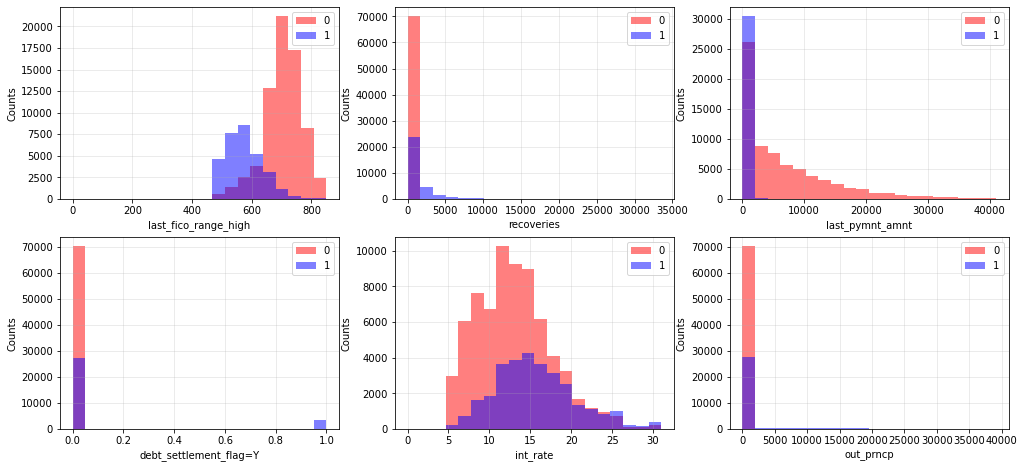

In [155]:
# Define size of the figure
plt.figure(figsize=(17, 12))

# For each column ...
for i_col in range(len(X_corr_for_plot)):
    
    # Create subplot for each column
    plt.subplot(3, 3, i_col+1)
    
    # Get column and label values
    x_col = data_preproc[X_corr_for_plot[i_col]].values
    y_col = data_preproc[y_column].values
    
    # Plot histograms
    bins = np.linspace(0, x_col.max(), 21)
    plt.grid(alpha = 0.3)
    plt.hist(x_col[y_col == 0], bins=bins, color='r', alpha=0.5, label='0')
    plt.hist(x_col[y_col == 1], bins=bins, color='b', alpha=0.5, label='1')
    
    # Labels and legend
    plt.xlabel(X_corr_for_plot[i_col])
    plt.ylabel('Counts')
    plt.legend(loc='best')
    
plt.show()

На основании построенных графиков можно сделать вывод о том, что факторы last_fico_range_high и last_pymnt_amnt имеет смысл убрать из дальнейшего анализа, так как значения по этим полям четко разделяют клиентов по целевой (т.е. по сути являются ее дублем). 
Также стоит убрать факторы recoveries и out_prncp. Это числовые поля, в которых содержатся суммы, но по сути все значения там 0, а наличие какой-либо сумму определяет состояние просроченного кредита. 
Показатель debt_settlement_flag=Y также стоит убрать, там 99% значений это 0, а факт наличия этого признака у клиента будет означать просрочку по кредиту.

Удалим эти показатели из наших данных.

In [156]:
data_preproc = data_preproc.drop(['last_fico_range_high',
'recoveries',
'last_pymnt_amnt',
'debt_settlement_flag=Y',
'out_prncp'], axis=1)

Теперь построим графики распределения целевой переменной среди наиболее важных на наш взгляд из оставшихся факторов:
- loan_amnt
- int_rate
- fico_range_high
- mths_since_last_delinq
- emp_length=10+ years
- acc_open_past_24mths

In [157]:
X_for_plot = data_preproc[['loan_amnt', 'int_rate', 'fico_range_high', 'mths_since_last_delinq', 'emp_length=10+ years', 'acc_open_past_24mths']].columns

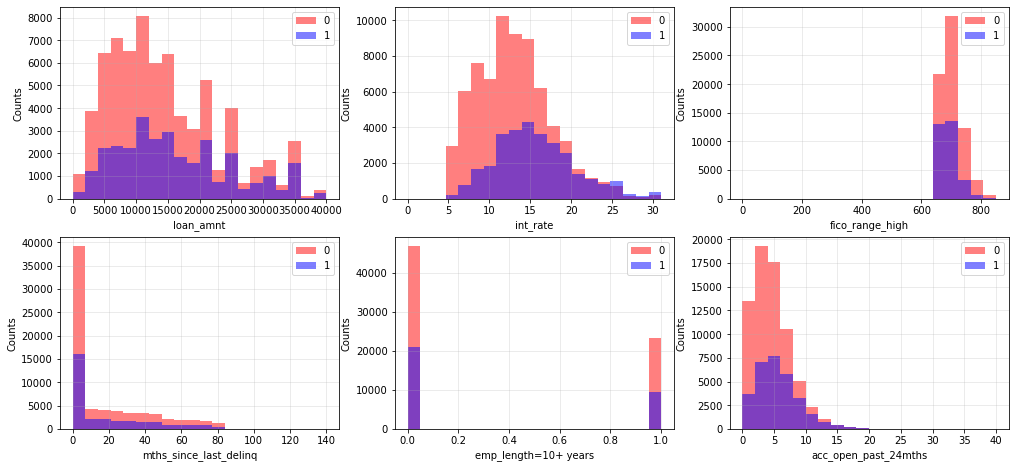

In [158]:
# Define size of the figure
plt.figure(figsize=(17, 12))

# For each column ...
for i_col in range(len(X_for_plot)):
    
    # Create subplot for each column
    plt.subplot(3, 3, i_col+1)
    
    # Get column and label values
    x_col = data_preproc[X_for_plot[i_col]].values
    y_col = data_preproc[y_column].values
    
    # Plot histograms
    bins = np.linspace(0, x_col.max(), 21)
    plt.grid(alpha = 0.3)
    plt.hist(x_col[y_col == 0], bins=bins, color='r', alpha=0.5, label='0')
    plt.hist(x_col[y_col == 1], bins=bins, color='b', alpha=0.5, label='1')
    
    # Labels and legend
    plt.xlabel(X_for_plot[i_col])
    plt.ylabel('Counts')
    plt.legend(loc='best')
    
plt.show()

Исходя из графиков выше мы видим, что:
- Чем выше у клиента кредитная задолженность, тем выше вероятность кредитного дефолта. 
- Аналогичную ситуацию мы видим по клиентам с низким кредитным рейтингом и по клиентам, у которых высокая процентная ставка.
- Чем меньше месяцев прошло с последней просрочки кредита, тем выше вероятность кредитного дефолта.
- Чем больше у клиента открытых счетов за последние 2 года, тем выше его вероятность просрочить кредит.
- Клиенты, у которых большой опыт работы, менее склонны к просрочке кредита.

# Построение моделей прогнозирования кредитного дефолта
В рамках построения будут строиться три модели:
- Логистическая регрессия.
- Random Forest.
- Gradient Boosting 

Для начала разделим наши исходные данные на обучающую (80%) и тестовую (20%) выборки.

In [159]:
y_column = 'loan_status'
X_columns = data_preproc.columns[data_preproc.columns != y_column]

X = data_preproc[X_columns]
y = data_preproc[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123)

Запишем функцию для сбора основных метрик оценки модели

In [160]:
def quality_report(prediction, prediction_prob, actual, model):
    quality_data = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'f1_score', 'ROC-AUC', 'Gini'], index=[model])
    
    quality_data['Accuracy'] = round(accuracy_score(prediction, actual), 3)
    quality_data['Precision'] = round(precision_score(prediction, actual), 3)
    quality_data['Recall'] = round(recall_score(prediction, actual), 3)
    quality_data['f1_score'] = round(f1_score(prediction, actual), 3)
    quality_data['ROC-AUC'] = round(roc_auc_score(actual, prediction_prob), 3)
    quality_data['Gini'] = round(2 * roc_auc_score(actual, prediction_prob) - 1, 3)
    
    return quality_data

### Построение логистической регрессии
Приступим к построению логистической регрессии. Для начала все числовые непрерывные переменные нужно преобразовать. Также по всем дамми переменным необходимо убрать один из уровней.
Создадим копии обучающего и тестового датасетов.

In [161]:
X_train_lr = X_train.copy()
X_train_lr = X_train_lr.reset_index(drop=True)
X_test_lr = X_test.copy()
X_test_lr = X_test_lr.reset_index(drop=True)

Стандартизируем числовые данные

In [162]:
num_cols_lr = list(num_cols.copy())
el_to_del = ['last_fico_range_high', 'recoveries', 'out_prncp', 'last_pymnt_amnt']

for elt in el_to_del:
    num_cols_lr.remove(elt)

In [163]:
scaler = StandardScaler()
X_train_scaler = pd.DataFrame(scaler.fit_transform(X_train_lr[num_cols_lr]), columns=num_cols_lr)
X_test_scaler = pd.DataFrame(scaler.transform(X_test_lr[num_cols_lr]), columns=num_cols_lr)

Теперь удалим исходные числовые данные и подсоединим стандартизированные

In [164]:
X_train_lr = X_train_lr.drop(num_cols_lr, axis=1)
X_test_lr = X_test_lr.drop(num_cols_lr, axis=1)

X_train_lr = pd.concat((X_train_lr, X_train_scaler), axis=1)
X_test_lr = pd.concat((X_test_lr, X_test_scaler), axis=1)

Теперь нужно удалить по одному признаку среди дамми факторов sub_grade, emp_length, purpose, home_ownership, verification_status. Как правило, удаляется тот уровень, в которое наибольшее количество наблюдений. Для определения базового уровня, мы можем обратиться к исходным данным.

In [175]:
dummy_cols = ['sub_grade', 'emp_length', 'purpose', 'home_ownership', 'verification_status']

for col in dummy_cols:
    df = pd.DataFrame(data[col].value_counts()).reset_index()
    print(col + '=' + df.iloc[0, 0])

sub_grade=C1
emp_length=10+ years
purpose=debt_consolidation
home_ownership=MORTGAGE
verification_status=Source Verified


Теперь удалим эти уровни из обучающей и тестовой выборок.

In [176]:
X_train_lr = X_train_lr.drop(['sub_grade=C1',
'emp_length=10+ years',
'purpose=debt_consolidation',
'home_ownership=MORTGAGE',
'verification_status=Source Verified'], axis=1)
X_test_lr = X_test_lr.drop(['sub_grade=C1',
'emp_length=10+ years',
'purpose=debt_consolidation',
'home_ownership=MORTGAGE',
'verification_status=Source Verified'], axis=1)

После всех преобразований построим модель на базовых параметрах и сделаем прогноз 

In [177]:
lr = LogisticRegression()
lr.fit(X_train_lr, y_train)
lr_pred = lr.predict(X_test_lr)
lr_pred_prob = lr.predict_proba(X_test_lr)[:, 1]

lr_report = quality_report(lr_pred, lr_pred_prob, y_test, 'Logistic Regression')
lr_report

,Accuracy,Precision,Recall,f1_score,ROC-AUC,Gini
Logistic Regression,0.749,0.351,0.664,0.459,0.768,0.535


Теперь попробуем подобрать более оптимальные параметры для нашей модели при помощи кросс-валидации. Запишем параметры, которые мы будем подбирать. В логистической регрессии это параметры регуляризации.

In [178]:
parameters_lr = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             'penalty':['none', 'elasticnet', 'l1', 'l2']}

В качестве максимизирующего признака будет использоваться Recall, так как мы хотим угадать больше клиентов, которые совершат просрочку.

In [179]:
lr_gs = GridSearchCV(lr,  
                  parameters_lr,
                  scoring='recall',
                  cv=5) 

lr_gs.fit(X_train_lr, y_train)
lr_gs.best_params_

{'C': 0.0001, 'penalty': 'none'}

In [180]:
lr_gs_pred = lr_gs.predict(X_test_lr)
lr_gs_pred_prob = lr_gs.predict_proba(X_test_lr)[:, 1]

lr_gs_report = quality_report(lr_gs_pred, lr_gs_pred_prob, y_test, 'Logistic Regression - GridSearch')
lr_gs_report

,Accuracy,Precision,Recall,f1_score,ROC-AUC,Gini
Logistic Regression - GridSearch,0.75,0.356,0.663,0.463,0.768,0.536


### Построение Random Forest
Приступим к построению модели Random Forest.

Построим модель на базовых параметрах и сделаем прогноз

In [182]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_pred_prob = rf.predict_proba(X_test)[:, 1]

rf_report = quality_report(rf_pred, rf_pred_prob, y_test, 'Random Forest')
rf_report

,Accuracy,Precision,Recall,f1_score,ROC-AUC,Gini
Random Forest,0.755,0.324,0.711,0.445,0.773,0.547


Теперь попробуем подобрать более оптимальные параметры для нашей модели при помощи кросс-валидации. Запишем параметры, которые мы будем подбирать. Это максимальная глубина, количество деревьев, максимальное количество факторов, подаваемых на вход, число сэмплов в бутстреп выборке.

In [185]:
parameters_rf = {'max_depth' : np.array(range(2, 10)),
                 'max_features' : [None, 'sqrt'],
                 'max_samples' : [None, 3],
                 'n_estimators' : [5, 10, 50, 100, 500]}

В качестве максимизирующего признака будет использоваться Recall, так как мы хотим угадать больше клиентов, которые совершат просрочку.

In [186]:
%%time

rf_gs = GridSearchCV(rf,  
                  parameters_rf,
                  scoring='recall',
                  cv=5) 

rf_gs.fit(X_train, y_train)
rf_gs.best_params_

Wall time: 40min 25s


{'max_depth': 9, 'max_features': None, 'max_samples': None, 'n_estimators': 50}

In [187]:
rf_gs_pred = rf_gs.predict(X_test)
rf_gs_pred_prob = rf_gs.predict_proba(X_test)[:, 1]

rf_gs_report = quality_report(rf_gs_pred, rf_gs_pred_prob, y_test, 'Random Forest - GridSearch')
rf_gs_report

,Accuracy,Precision,Recall,f1_score,ROC-AUC,Gini
Random Forest - GridSearch,0.761,0.342,0.722,0.464,0.788,0.576


### Построение градиетного бустинга.
Приступим к построению модели градиетного бустинга

In [188]:
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_pred_prob = lgbm.predict_proba(X_test)[:, 1]

lgbm_report = quality_report(lgbm_pred, lgbm_pred_prob, y_test, 'LightGBM')
lgbm_report

,Accuracy,Precision,Recall,f1_score,ROC-AUC,Gini
LightGBM,0.784,0.464,0.726,0.566,0.821,0.642


Теперь попробуем подобрать более оптимальные параметры для нашей модели при помощи кросс-валидации. Запишем параметры, которые мы будем подбирать. Это максимальная глубина, количество деревьев и скорость обучения.

In [189]:
parameters_gb = {'max_depth' : np.array(range(3, 10)),
             'learning_rate' : [0.001, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3],
             'n_estimators' : np.array(range(20, 120, 20))}

В качестве максимизирующего признака будет использоваться Recall, так как мы хотим угадать больше клиентов, которые совершат просрочку.

In [190]:
%%time
lgbm_gs = GridSearchCV(lgbm,  
                  parameters_gb,
                  scoring='recall',
                  cv=5) 

lgbm_gs.fit(X_train, y_train)
lgbm_gs.best_params_

Wall time: 12min 48s


{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 100}

In [191]:
lgbm_gs_pred = lgbm_gs.predict(X_test)
lgbm_gs_pred_prob = lgbm_gs.predict_proba(X_test)[:, 1]

lgbm_gs_report = quality_report(lgbm_gs_pred, lgbm_gs_pred_prob, y_test, 'LightGBM - GridSearch')
lgbm_gs_report

,Accuracy,Precision,Recall,f1_score,ROC-AUC,Gini
LightGBM - GridSearch,0.791,0.509,0.718,0.596,0.823,0.645


## Сравнение моделей
Сравним все варианты моделей

In [192]:
models_report = pd.concat([lr_report, lr_gs_report, rf_report, rf_gs_report, lgbm_report, lgbm_gs_report])
models_report

,Accuracy,Precision,Recall,f1_score,ROC-AUC,Gini
Logistic Regression,0.749,0.351,0.664,0.459,0.768,0.535
Logistic Regression - GridSearch,0.750,0.356,0.663,0.463,0.768,0.536
Random Forest,0.755,0.324,0.711,0.445,0.773,0.547
Random Forest - GridSearch,0.761,0.342,0.722,0.464,0.788,0.576
LightGBM,0.784,0.464,0.726,0.566,0.821,0.642
LightGBM - GridSearch,0.791,0.509,0.718,0.596,0.823,0.645


Из таблицы видно, что лучший результат по всем метрикам показывает модель, построенная на с использованием градиетного бустинга после кросс-валидации. Также можем наблюдать, что за счет кросс-валидации мы улучшаеем все модели.